# BitPredict: Predicting Bitcoin Price in real time. A time series forecasting problem


Time series problems are those which deals with data over time. Such as growth of population in a country or the amount of electricity used by a nation. Timeline can either be very short and in seconds or be very long in decades. A forecasting problems like ours predicts future demands and settles the matter likewise.


In [1]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2014-11-04_2022-01-01-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])

df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145
...,...,...,...,...,...
2021-12-28,BTC,50696.802160,50792.240989,52061.640000,50480.200000
2021-12-29,BTC,47535.309698,50696.802023,50709.972512,47318.930000
2021-12-30,BTC,46471.230000,47535.919464,48130.998494,46120.000000


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2616 entries, 2014-11-04 to 2022-01-01
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2616 non-null   object 
 1   Closing Price (USD)  2616 non-null   float64
 2   24h Open (USD)       2616 non-null   float64
 3   24h High (USD)       2616 non-null   float64
 4   24h Low (USD)        2616 non-null   float64
dtypes: float64(4), object(1)
memory usage: 122.6+ KB


We've collected the historical price of bitcoin for past 7years and 4 months with only 2616 samples.

Typically, deep learning loves millions of samples of data.

However, a small data sample is something you always run into with time series forecasting/classification data.

> **NOTE:** The seasonality of a time series dataset is the number of samples generated per year. Our bitcoin dataset has a seasonality of daily with a value of 365 as we collect data once a day.

In [3]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)" : "Price"})
bitcoin_prices

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2021-12-28,50696.802160
2021-12-29,47535.309698
2021-12-30,46471.230000


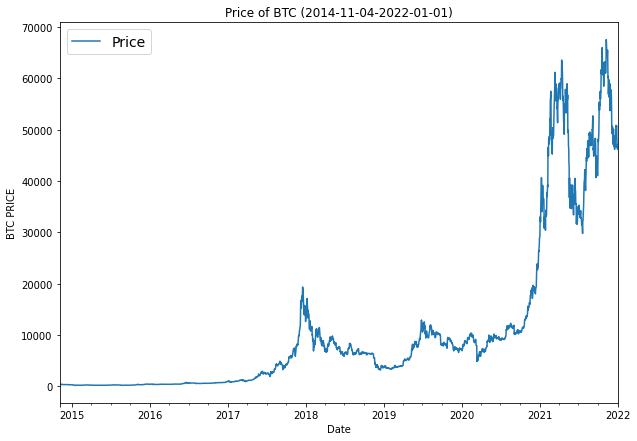

In [4]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize = (10,7))
plt.ylabel("BTC PRICE")
plt.title("Price of BTC (2014-11-04-2022-01-01)")
plt.legend(fontsize = 14)

## Format Data Part 1: Creatining train and test sets for time series data

* **Univariate** time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

### Create train and test sets for time series



In [5]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]))

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2014-11-04_2022-01-01-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0),
  datetime.datetime(2014, 11, 13, 0, 0)],
 [324.467934,
  328.644408,
  337.921358,
  348.99286,
  341.459753,
  344.745289,
  357.239982,
  371.116917,
  366.664633,
  428.882925])

In [7]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2092, 524, 2092, 524)

## Create a plotting function

In [8]:
def plot_time_series(timesteps, values, format = '.', start = 0, end = None, label = None):
  plt.plot(timesteps[start:end], values[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

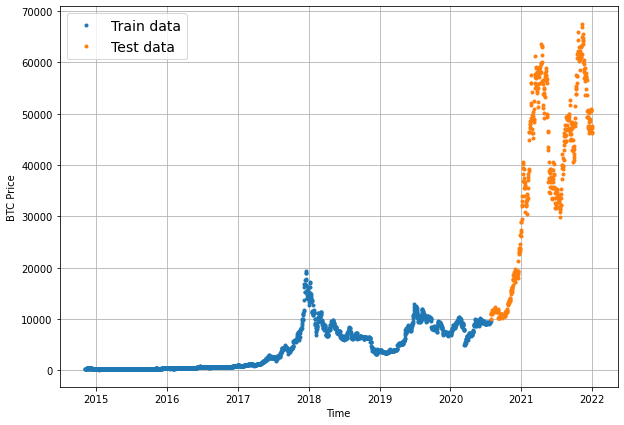

In [9]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

Experiments we are running (Horizon/Window)

0. Naïve model (baseline)
2. Dense model 1/7
6. LSTM 1/7
8. N-Beats 1/7
9. Ensemble (multiple models optimized on different loss functions) 1/7



## Model 0 : Nave Baseline Forecast


The formula looks like this:

y`(t) = y(t-1)

In [10]:
nf = y_test[:-1] # creating naive forecast using above formula

nf[:10] , nf[-10:]

(array([ 9940.53292 , 11045.5     , 10933.5     , 11110.779249,
        11112.39206 , 11351.67    , 11816.057687, 11065.305792,
        11237.354858, 11194.363266]),
 array([48921.134112, 48610.619112, 50807.      , 50834.3     ,
        50430.073507, 50792.036921, 50696.80216 , 47535.309698,
        46471.23    , 47128.468155]))

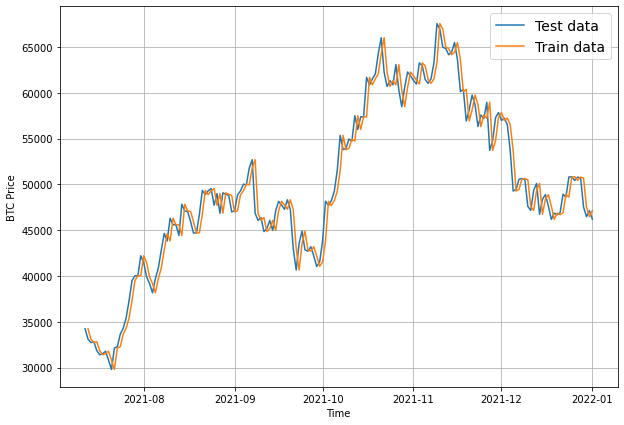

In [11]:
# Ploting naive forecast
plt.figure(figsize = (10,7))
plot_time_series(X_test, y_test, start=350, format = "-", label = "Test data")
plot_time_series(X_test[1:],nf, start= 350, format = "-", label = "Train data")

## Evaluating a time series model

Since we are predicting a number- its a regression problem.

Since we are working on regression, we'll use regression alike metrics like `mae` or `mse`

In [12]:
import tensorflow as tf

# MASE IMPLEMENTATION

def mean_absolute_scaled_error(y_true, y_preds):

  mae = tf.reduce_mean(tf.abs(y_true - y_preds))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae/ mae_naive_no_season

In [13]:
mean_absolute_scaled_error(y_test[1:], nf).numpy()

0.999999880809088

In [14]:
## just in case we are forced to work with other size horizons and windows in the future, lets make our function account for it.

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [15]:
naive_results = evaluate_preds(y_test[1:],
                               nf)
naive_results

{'mae': 1105.0359,
 'mape': 2.8452072,
 'mase': 0.9999999,
 'mse': 2662678.0,
 'rmse': 1631.7715}

## Format Data Part 2 : Windowing our dataset

We window our time series dataset to turn data into a supervised learning problem

```
[0,1,2,3,4,5,6]->[7]
[1,2,3,4,5,6,7]->[8]
[2,3,4,5,6,7,8]->[9]
```

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

In [16]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [17]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [18]:
import tensorflow as tf
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We could use a python for loop for this, but since our data is huge we'll use numpy array data indexing instead.

Our function will
1. Create a window step of specific window size eg: `[0,1,2,3,4,5,6]`
2. Use NumPy indexing to create a 2D array of multiple window steps
```
[[0,1,2,3,4,5,6]
[0,1,2,3,4,5,6]
[2,3,4,5,6,7,8]]
```
3. Uses the 2D array of multiple window steps to index of a target series
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with specified horizons

In [19]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  wstep = np.expand_dims(np.arange(window_size+horizon), axis=0)
  wid = wstep + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  warray = x[wid]
  windows, labels = get_labelled_windows(warray, horizon=horizon)

  return windows, labels

In [20]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2609, 2609)

### Turning windows into training and test sets

In [21]:
def make_train_test_splits(windows, labels, test_split = 0.2):
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [22]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2087, 522, 2087, 522)

In [ ]:
train_windows[:5], train_labels[:5]


(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218]]), array([[371.116917],
        [366.664633],
        [428.882925],
        [418.944218],
        [399.688315]]))

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare them.

We will compare model performance on the best epoch of all models.

In [23]:
import os 
# create model checkpoint
def checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbosity = 0,
                                            save_best_only = True)

## Model 1 : Dense Model (window=7, horizon=1)

Our first deep model is going to be a simple dense model and is going to have the following parameters:
1. A single dense layer with 128 hidden units and ReLu activation.
2. An output layer with linear none activation.
3. Adam optimization and MAE loss function.
4. Batch size of 128
5. Run for a 100 epochs

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# 1. Construct a model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation = "relu"),
  layers.Dense(HORIZON, activation = "linear")
], name = "model_1_dense")

# 2. Compile
model_1.compile(loss ="mae",
                optimizer = "Adam",
                metrics = ["mae","mse"])

# 3. Fit
model_1.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [checkpoint(model_name = model_1.name)])

Epoch 1/100
17/17 [==============================] - 2s 70ms/step - loss: 1080.3732 - mae: 1080.3732 - mse: 3381598.7500 - val_loss: 4790.0581 - val_mae: 4790.0581 - val_mse: 35939408.0000
Epoch 2/100
17/17 [==============================] - 1s 41ms/step - loss: 347.4054 - mae: 347.4054 - mse: 384803.4688 - val_loss: 1911.1781 - val_mae: 1911.1781 - val_mse: 7077429.0000
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 256.7770 - mae: 256.7770 - mse: 245708.8906 - val_loss: 1931.0037 - val_mae: 1931.0037 - val_mse: 6863813.0000
Epoch 4/100
17/17 [==============================] - 1s 41ms/step - loss: 223.1010 - mae: 223.1010 - mse: 197263.4062 - val_loss: 1728.9130 - val_mae: 1728.9130 - val_mse: 6039790.5000
Epoch 5/100
17/17 [==============================] - 1s 41ms/step - loss: 210.6120 - mae: 210.6120 - mse: 185582.4531 - val_loss: 1683.3984 - val_mae: 1683.3984 - val_mse: 5493721.5000
Epoch 6/100
17/17 [==============================] - 1s 41ms/step - loss

In [25]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)


17/17 [==============================] - 0s 3ms/step - loss: 1154.0116 - mae: 1154.0116 - mse: 2799967.5000


[1154.0115966796875, 1154.0115966796875, 2799967.5]

In [26]:
# Load in saved best performing model_1 and evaluate it on test_data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)


17/17 [==============================] - 0s 3ms/step - loss: 1112.2589 - mae: 1112.2589 - mse: 2711870.2500


[1112.2589111328125, 1112.2589111328125, 2711870.25]

## Making forcasts with a model (on test datasets)

1. Take in a trained model
2. Takes in some input data of the kind upon which it was trained on.
3. Passes the input data to the model's `predict()`
4. Returns the predictions


In [27]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [28]:
m1_preds = make_preds(model_1, test_windows)
m1_results = evaluate_preds(tf.squeeze(test_labels), m1_preds)
m1_results

{'mae': 1112.2588,
 'mape': 2.8359742,
 'mase': 1.0048031,
 'mse': 2711870.0,
 'rmse': 1646.7758}

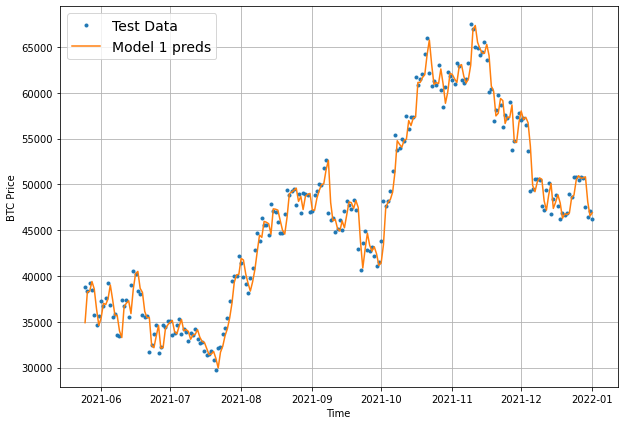

In [29]:
# Lets plot our model 1 predictions
offset = 300
plt.figure(figsize = (10,7))
# Account for offset by indexing
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 start = offset,
                 label = "Test Data")

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = m1_preds,
                 start = offset,
                 format = "-",
                 label = "Model 1 preds")

## Which of our models are performing the best so far?

We've trained a few models, now lets compare them and see how they've gone


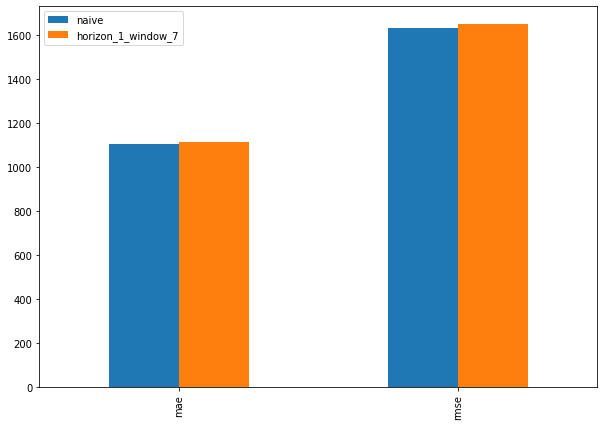

In [30]:
pd.DataFrame({"naive": [naive_results["mae"] , naive_results["rmse"]], 
              "horizon_1_window_7": [m1_results["mae"] , m1_results["rmse"]]}, index=["mae" , "rmse"]).plot(figsize=(10, 7), kind="bar");

## Model 2 : RNN - LSTM

Let's build an RNN model for our time series data and we'll use the same data which we used previously. 

In [31]:
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x, axis = 1))(inputs)
x = layers.LSTM(128, activation = "relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_2 = tf.keras.Model(inputs, outputs , name = "model_2_LSTM")


model_2.compile(loss = "mae",
                optimizer = "Adam")

# Fitting the model
model_2.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [checkpoint(model_name = model_2.name)])

Epoch 1/100
16/17 [===========================>..] - ETA: 0s - loss: 3278.0579INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 4s 176ms/step - loss: 3266.6018 - val_loss: 19408.2324
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 1339.8540INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 1339.8540 - val_loss: 2605.6687
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 339.0145INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 139ms/step - loss: 339.0145 - val_loss: 1801.9974
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 243.8647 - val_loss: 1844.7241
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 229.4398 - val_loss: 1858.4532
Epoch 6/100
17/17 [==============================] - ETA: 0s - loss: 220.1644INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 161ms/step - loss: 220.1644 - val_loss: 1788.2474
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 218.1684 - val_loss: 1788.3770
Epoch 8/100
15/17 [=========================>....] - ETA: 0s - loss: 219.6407INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 141ms/step - loss: 216.5959 - val_loss: 1770.1074
Epoch 9/100
17/17 [==============================] - 0s 9ms/step - loss: 215.5635 - val_loss: 1770.2234
Epoch 10/100
17/17 [==============================] - ETA: 0s - loss: 214.0159INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 139ms/step - loss: 214.0159 - val_loss: 1737.4209
Epoch 11/100
17/17 [==============================] - ETA: 0s - loss: 212.6667INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 163ms/step - loss: 212.6667 - val_loss: 1723.9016
Epoch 12/100
17/17 [==============================] - 0s 9ms/step - loss: 210.7815 - val_loss: 1740.2880
Epoch 13/100
17/17 [==============================] - ETA: 0s - loss: 209.1857INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 209.1857 - val_loss: 1702.0363
Epoch 14/100
16/17 [===========================>..] - ETA: 0s - loss: 208.5044INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 140ms/step - loss: 207.5939 - val_loss: 1691.8276
Epoch 15/100
17/17 [==============================] - 0s 9ms/step - loss: 204.7518 - val_loss: 1693.3845
Epoch 16/100
17/17 [==============================] - ETA: 0s - loss: 203.0015INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 162ms/step - loss: 203.0015 - val_loss: 1649.9044
Epoch 17/100
16/17 [===========================>..] - ETA: 0s - loss: 202.5701INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 201.4809 - val_loss: 1642.0032
Epoch 18/100
17/17 [==============================] - ETA: 0s - loss: 198.5458INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 198.5458 - val_loss: 1619.5024
Epoch 19/100
15/17 [=========================>....] - ETA: 0s - loss: 193.4766INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 159ms/step - loss: 196.6174 - val_loss: 1606.8521
Epoch 20/100
17/17 [==============================] - ETA: 0s - loss: 195.0635INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 144ms/step - loss: 195.0635 - val_loss: 1601.8149
Epoch 21/100
17/17 [==============================] - 0s 9ms/step - loss: 193.1684 - val_loss: 1609.8271
Epoch 22/100
17/17 [==============================] - 0s 9ms/step - loss: 195.8001 - val_loss: 1643.9988
Epoch 23/100
17/17 [==============================] - ETA: 0s - loss: 187.7156INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 187.7156 - val_loss: 1598.9417
Epoch 24/100
17/17 [==============================] - ETA: 0s - loss: 187.1179INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 140ms/step - loss: 187.1179 - val_loss: 1527.8656
Epoch 25/100
17/17 [==============================] - ETA: 0s - loss: 187.6975INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 166ms/step - loss: 187.6975 - val_loss: 1507.1317
Epoch 26/100
17/17 [==============================] - 0s 8ms/step - loss: 182.9133 - val_loss: 1547.7375
Epoch 27/100
17/17 [==============================] - 0s 8ms/step - loss: 180.5376 - val_loss: 1544.2164
Epoch 28/100
17/17 [==============================] - ETA: 0s - loss: 179.0605INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 140ms/step - loss: 179.0605 - val_loss: 1463.6221
Epoch 29/100
17/17 [==============================] - 0s 9ms/step - loss: 179.7611 - val_loss: 1469.6243
Epoch 30/100
17/17 [==============================] - 0s 10ms/step - loss: 174.9553 - val_loss: 1472.2386
Epoch 31/100
16/17 [===========================>..] - ETA: 0s - loss: 173.9440INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 173.0550 - val_loss: 1416.9398
Epoch 32/100
17/17 [==============================] - 0s 10ms/step - loss: 169.2865 - val_loss: 1460.1835
Epoch 33/100
16/17 [===========================>..] - ETA: 0s - loss: 167.6414INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 162ms/step - loss: 168.3313 - val_loss: 1388.2098
Epoch 34/100
17/17 [==============================] - 0s 9ms/step - loss: 167.6601 - val_loss: 1405.2225
Epoch 35/100
17/17 [==============================] - 0s 8ms/step - loss: 163.3183 - val_loss: 1390.6952
Epoch 36/100
 9/17 [==============>...............] - ETA: 0s - loss: 165.3234INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 144ms/step - loss: 161.7565 - val_loss: 1350.6622
Epoch 37/100
17/17 [==============================] - 0s 9ms/step - loss: 160.8534 - val_loss: 1352.3354
Epoch 38/100
17/17 [==============================] - 0s 10ms/step - loss: 163.2776 - val_loss: 1432.4916
Epoch 39/100
17/17 [==============================] - ETA: 0s - loss: 159.9959INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 141ms/step - loss: 159.9959 - val_loss: 1343.5201
Epoch 40/100
17/17 [==============================] - 0s 10ms/step - loss: 158.5042 - val_loss: 1353.7085
Epoch 41/100
17/17 [==============================] - ETA: 0s - loss: 156.4820INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 161ms/step - loss: 156.4820 - val_loss: 1326.0616
Epoch 42/100
17/17 [==============================] - ETA: 0s - loss: 157.7234INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 143ms/step - loss: 157.7234 - val_loss: 1314.3241
Epoch 43/100
17/17 [==============================] - ETA: 0s - loss: 158.9388INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 158.9388 - val_loss: 1305.2191
Epoch 44/100
17/17 [==============================] - ETA: 0s - loss: 157.6874INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 160ms/step - loss: 157.6874 - val_loss: 1301.6168
Epoch 45/100
17/17 [==============================] - 0s 8ms/step - loss: 152.7335 - val_loss: 1329.6708
Epoch 46/100
16/17 [===========================>..] - ETA: 0s - loss: 155.1378INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 145ms/step - loss: 155.0965 - val_loss: 1267.3672
Epoch 47/100
17/17 [==============================] - 0s 9ms/step - loss: 151.1288 - val_loss: 1268.4801
Epoch 48/100
17/17 [==============================] - ETA: 0s - loss: 149.5797INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 147ms/step - loss: 149.5797 - val_loss: 1258.4572
Epoch 49/100
17/17 [==============================] - 0s 9ms/step - loss: 149.0423 - val_loss: 1285.0750
Epoch 50/100
16/17 [===========================>..] - ETA: 0s - loss: 148.6815INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 168ms/step - loss: 149.5207 - val_loss: 1247.3384
Epoch 51/100
17/17 [==============================] - ETA: 0s - loss: 153.1578INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 147ms/step - loss: 153.1578 - val_loss: 1245.4272
Epoch 52/100
15/17 [=========================>....] - ETA: 0s - loss: 152.7963INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 151ms/step - loss: 150.5272 - val_loss: 1238.8140
Epoch 53/100
17/17 [==============================] - 0s 9ms/step - loss: 153.7897 - val_loss: 1314.6575
Epoch 54/100
17/17 [==============================] - ETA: 0s - loss: 147.8028INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 150ms/step - loss: 147.8028 - val_loss: 1236.3898
Epoch 55/100
16/17 [===========================>..] - ETA: 0s - loss: 147.1160INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 175ms/step - loss: 146.3885 - val_loss: 1227.3365
Epoch 56/100
17/17 [==============================] - 0s 10ms/step - loss: 147.9531 - val_loss: 1258.3776
Epoch 57/100
16/17 [===========================>..] - ETA: 0s - loss: 147.5798INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 153ms/step - loss: 147.0709 - val_loss: 1221.7922
Epoch 58/100
17/17 [==============================] - 0s 10ms/step - loss: 145.5649 - val_loss: 1225.3138
Epoch 59/100
17/17 [==============================] - 0s 10ms/step - loss: 146.4210 - val_loss: 1237.2473
Epoch 60/100
14/17 [=======================>......] - ETA: 0s - loss: 143.6136INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 149ms/step - loss: 144.7848 - val_loss: 1211.0857
Epoch 61/100
15/17 [=========================>....] - ETA: 0s - loss: 145.2064INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 166ms/step - loss: 144.4642 - val_loss: 1210.1976
Epoch 62/100
17/17 [==============================] - 0s 10ms/step - loss: 146.8163 - val_loss: 1224.8751
Epoch 63/100
17/17 [==============================] - 0s 10ms/step - loss: 146.8148 - val_loss: 1234.4796
Epoch 64/100
16/17 [===========================>..] - ETA: 0s - loss: 144.9575INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 151ms/step - loss: 145.7820 - val_loss: 1209.6998
Epoch 65/100
16/17 [===========================>..] - ETA: 0s - loss: 150.1913INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 148ms/step - loss: 149.6701 - val_loss: 1200.4331
Epoch 66/100
17/17 [==============================] - 0s 10ms/step - loss: 144.7763 - val_loss: 1252.3286
Epoch 67/100
14/17 [=======================>......] - ETA: 0s - loss: 146.1960INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 171ms/step - loss: 148.1511 - val_loss: 1197.5573
Epoch 68/100
17/17 [==============================] - 0s 9ms/step - loss: 143.3920 - val_loss: 1227.4919
Epoch 69/100
17/17 [==============================] - 0s 10ms/step - loss: 148.1148 - val_loss: 1309.8710
Epoch 70/100
17/17 [==============================] - 0s 10ms/step - loss: 166.7706 - val_loss: 1318.8625
Epoch 71/100
17/17 [==============================] - 0s 10ms/step - loss: 155.3853 - val_loss: 1325.5269
Epoch 72/100
17/17 [==============================] - 0s 10ms/step - loss: 155.4531 - val_loss: 1335.3998
Epoch 73/100
17/17 [==============================] - 0s 9ms/step - loss: 153.7899 - val_loss: 1281.9791
Epoch 74/100
17/17 [==============================] - 0s 10ms/step - loss: 151.8372 - val_loss: 1297.2097
Epoch 75/100
17/17 [==============================] - 0s 10ms/step - loss: 151.0853 - val_loss: 1278.7262
Epoch 76/100
17/17 [==============================] - 0s 10m

INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 148ms/step - loss: 145.3342 - val_loss: 1189.1757
Epoch 95/100
15/17 [=========================>....] - ETA: 0s - loss: 140.1437INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 148ms/step - loss: 142.6550 - val_loss: 1187.6344
Epoch 96/100
17/17 [==============================] - 0s 10ms/step - loss: 146.1743 - val_loss: 1298.2767
Epoch 97/100
15/17 [=========================>....] - ETA: 0s - loss: 146.9657INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 3s 167ms/step - loss: 146.0518 - val_loss: 1187.3547
Epoch 98/100
17/17 [==============================] - 0s 9ms/step - loss: 140.8499 - val_loss: 1193.1505
Epoch 99/100
17/17 [==============================] - 0s 10ms/step - loss: 143.6575 - val_loss: 1196.0957
Epoch 100/100
15/17 [=========================>....] - ETA: 0s - loss: 141.4727INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM/assets


17/17 [==============================] - 2s 151ms/step - loss: 140.7938 - val_loss: 1179.8011


In [32]:
# Load in best model_2
model_2 = tf.keras.models.load_model("model_experiments/model_2_LSTM")
model_2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 1179.8011


1179.8011474609375

In [33]:
m2_preds = make_preds(model_2,test_windows)
m2_results = evaluate_preds(tf.squeeze(test_labels), m2_preds)
m2_results

{'mae': 1179.8011,
 'mape': 3.0076578,
 'mase': 1.0658202,
 'mse': 2940976.5,
 'rmse': 1714.9275}

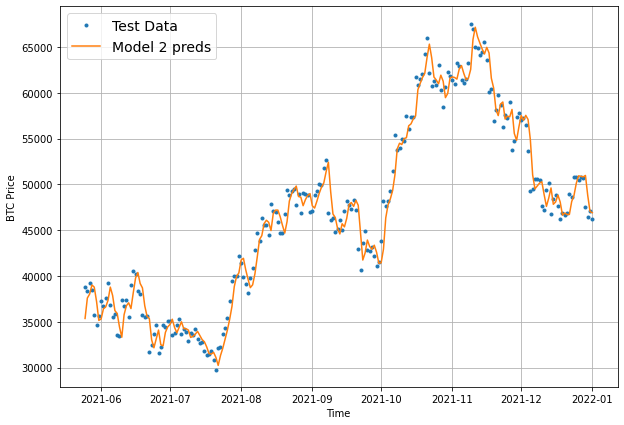

In [34]:
# Lets plot our model 2 predictions
offset = 300
plt.figure(figsize = (10,7))
# Account for offset by indexing
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:,0],
                 start = offset,
                 label = "Test Data")

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = m2_preds,
                 start = offset,
                 format = "-",
                 label = "Model 2 preds")

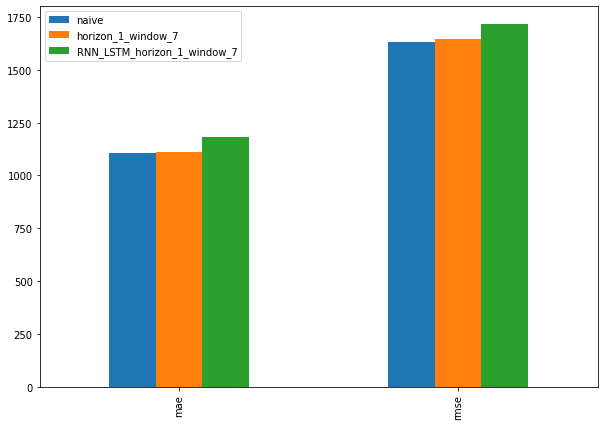

In [35]:
pd.DataFrame({"naive": [naive_results["mae"] , naive_results["rmse"]], 
              "horizon_1_window_7": [m1_results["mae"] , m1_results["rmse"]],
              "RNN_LSTM_horizon_1_window_7" : [m2_results["mae"] , m2_results["rmse"]]}, index=["mae" , "rmse"]).plot(figsize=(10, 7), kind="bar");

Building a neural networks algorithm doesn't necessarily mean that it will outperform all other models.

## MODEL 3 : N-BEATS algorithm

lets now try to build the biggest time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in the following paper : https://arxiv.org/pdf/1905.10437.pdf

Why ?

* This will allow us to practice replicating a paper with tensorflow code
* We will see how to use tensorflow layer subclassing 
* Get experience using the functional API to create a custom architecture
* Create a state of the art model with exceptional results

### Building and test N-BEATs block layer

Because the N-Beats block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layersand model in TensorFlow, we can use subclassing:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

In [36]:
class NBeatsBlock(tf.keras.layers.Layer):
  def  __init__(self,
                input_size : int,
                theta_size : int,
                horizon : int,
                n_neurons : int,
                n_layers : int,
                **kwargs): # Takes care of arguments in parent class like input_shape etc
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block Contains stack of 4 fully connect layers each has relu activation
    self.hidden =[tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size,
                                             activation = "linear",
                                             name = "theta")
    
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size] , theta[:,-self.horizon:]

    return backcast, forecast



Lets test our NBeatsBlock Class.

To do so we'll make some dummy inputs and outputs

In [37]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON,
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [38]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis = 0) # inputs shape to the model to reflect dense layer
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [39]:
# Pass dummy inputs into the block layer
backcast , forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activations outputs of the theta layers (they'll be random due to no training)

print(f"Backcast : {tf.squeeze(backcast.numpy())}")
print(f"Forecast : {tf.squeeze(forecast.numpy())}")

Backcast : [-0.4634872   0.10944451 -0.4335534   0.93602407 -0.35703534 -0.17927621
 -0.34048355]
Forecast : -0.4397900700569153


### Preparing data for the N-Beats algorithm using `tf.data.`

To make our input data load as fast as possible then we're going to be adhering to the performant data pipeline steps in tf.data guide

In [40]:
HORIZON = 1
WINDOW_SIZE = 7

In [41]:
# create nbeats data inputs (N-beats works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


In [42]:
# Add windowed columns 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-28,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112,48921.134112,46910.249593
2021-12-29,47535.309698,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112,48921.134112
2021-12-30,46471.230000,47535.309698,50696.802160,50792.036921,50430.073507,50834.300000,50807.000000,48610.619112


In [43]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis = 1)
y = bitcoin_prices_nbeats.dropna()["Price"]

ss = int(len(X)*0.8)
X_train, y_train = X[:ss] , y[:ss]
X_test, y_test = X[ss:] , y[ss:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2087, 522, 2087, 522)

In [44]:
# Time to make our dataset performany
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_label_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_label_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_label_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_label_dataset))

# batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-Beats algorithm

The N-Beats algorithm has a fair few number of parameters, many of them found here in table 18 : https://arxiv.org/pdf/1905.10437.pdf

In [45]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE , THETA_SIZE

(7, 8)

### Building, compiling and fitting N-Beats Algorithm

1. Setup an instance of the N-beats block layer using `NBeatsBlock` , which will be the initial block used for the network with the rest being worked as a part of stacks
2. Create an input layer for the N-Beats stack which we will execute using Keras Functional API
3. Make the initial backcast and forecasts for the model with the layer created in __1__
4. Use `for` loop to create stack of block layers
5. We will use the `NBeatsBlock` class within the for loop __4__ to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using substract and add layers
7. Put them model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss. We'll use MAE To keep in accordance with the model along with Adam optimizer with default settings as described in the paper.
9. Fit the N-Beats model for 5000 epochs and since it's fitting for so many epochs we'll use a couple of callbacks:
  * Early Stopping - stops the model early if it overfits or stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce th amount by which it updates it's weights each time for increasing performance

In [46]:
 %%time

tf.random.set_seed(42)

#setup nbeats block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

#give inputs to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

#create initial backcast and forecast
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

#stack the n beats blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_3 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_3_N-BEATS")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model_3.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])




Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00421: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00521: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 47s, sys: 4.44 s, total: 3min 51s
Wall time: 5min 1s


In [47]:
# Evaluate N-BEATS model on the test dataset
model_3.evaluate(test_dataset)

1/1 [==============================] - 0s 61ms/step - loss: 1141.8810 - mae: 1141.8810 - mse: 2897429.5000


[1141.8809814453125, 1141.8809814453125, 2897429.5]

In [48]:
# Make predictions with N-BEATS model
m3_preds = make_preds(model_3, test_dataset)
# Evaluate N-BEATS model predictions
m3_results = evaluate_preds(y_true=y_test,y_pred=m3_preds)
m3_results

{'mae': 1141.881,
 'mape': 2.9164894,
 'mase': 1.0315635,
 'mse': 2897429.5,
 'rmse': 1702.1837}

In [53]:
m3_preds

<tf.Tensor: shape=(522,), dtype=float32, numpy=
array([11040.927 , 11103.456 , 11154.792 , 11141.063 , 11192.0625,
       11795.051 , 11257.4795, 11225.894 , 11232.239 , 11611.005 ,
       11785.535 , 11655.702 , 11779.371 , 11723.7   , 11877.066 ,
       11602.453 , 11561.306 , 11810.862 , 11791.525 , 11874.7705,
       11929.265 , 12208.115 , 12063.563 , 11845.379 , 11906.684 ,
       11666.19  , 11755.52  , 11721.991 , 11768.287 , 11533.9375,
       11466.134 , 11458.099 , 11536.04  , 11554.673 , 11655.049 ,
       11698.392 , 11859.021 , 11597.863 , 10450.167 , 10250.998 ,
       10216.376 , 10570.11  , 10391.17  , 10267.039 , 10276.002 ,
       10352.934 , 10402.959 , 10458.6   , 10384.474 , 10609.76  ,
       10752.032 , 10902.201 , 10989.905 , 10955.548 , 11081.105 ,
       11007.072 , 10644.715 , 10548.832 , 10316.37  , 10696.729 ,
       10737.997 , 10707.765 , 10815.289 , 10719.172 , 10844.909 ,
       10838.891 , 10726.105 , 10666.723 , 10619.759 , 10711.527 ,
       10791.2

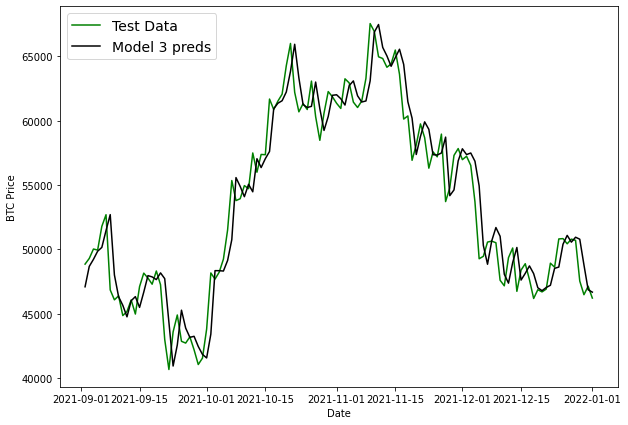

In [57]:
# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=400
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], m3_preds[offset:], "k-", label="Model 3 preds")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(loc="upper left", fontsize=14);

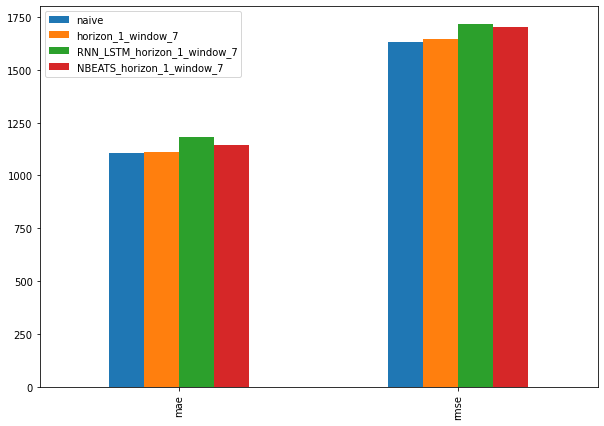

In [50]:
pd.DataFrame({"naive": [naive_results["mae"] , naive_results["rmse"]], 
              "horizon_1_window_7": [m1_results["mae"] , m1_results["rmse"]],
              "RNN_LSTM_horizon_1_window_7" : [m2_results["mae"] , m2_results["rmse"]],
              "NBEATS_horizon_1_window_7" : [m3_results["mae"], m3_results["rmse"] ]}, index=["mae" , "rmse"]).plot(figsize=(10, 7), kind="bar");

### Plotting the N-Beats architecture

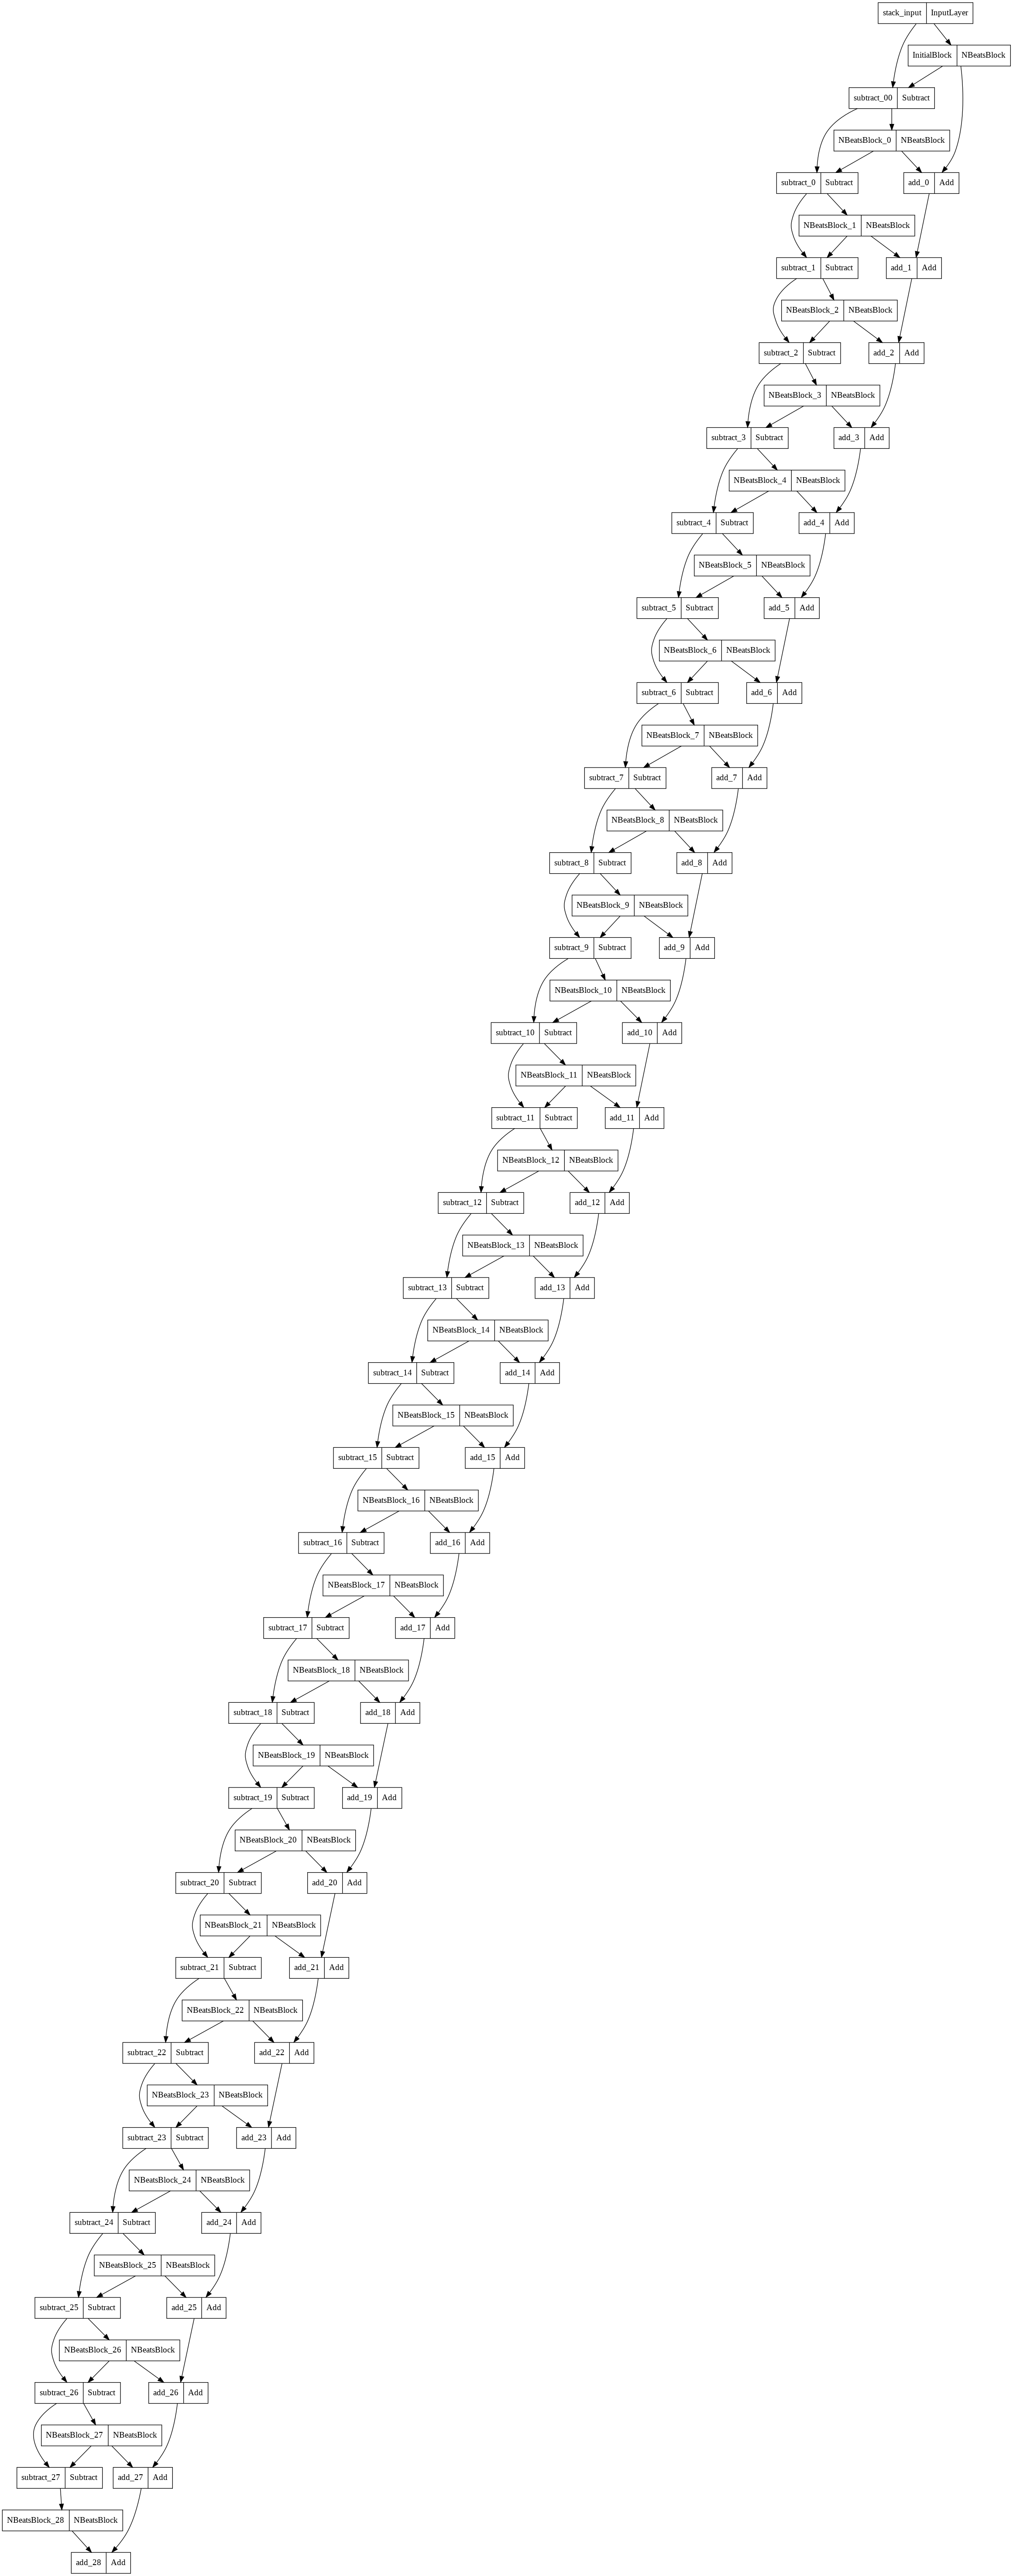

In [58]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_3)

## Model 4 : create an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect, it combined many different models to predicts a common goal

### Constructing and fitting an ensemble of models (using different loss functions)

In [60]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae","mse","mape"]):

  # Make emplty list for trained ensemble models
  ensemble_models = []

  # Create num_iter moders loss fn
  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing : {loss_function} for {num_epochs} epochs, model number : {i}")

      model = tf.keras.Sequential([
        layers.Dense(128,kernel_initializer = "he_normal", activation="relu"),
        layers.Dense(128,kernel_initializer = "he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(loss = loss_function,
                    optimizer = "Adam",
                    metrics = ["mae","mse"])
      
      model.fit(train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data= test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience = 200,
                                                               restore_best_weights = True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      
      ensemble_models.append(model)
  
  return ensemble_models

In [61]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing : mae for 1000 epochs, model number : 0
Optimizing model by reducing : mse for 1000 epochs, model number : 0

Epoch 00540: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00640: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mape for 1000 epochs, model number : 0

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing : mae for 1000 epochs, model number : 1

Epoch 00691: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00875: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00975: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing : mse for 1000 epochs, model number : 1

Epoch 00444: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00544: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05

### Make predictions with our ensemble models

In [62]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) 
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [63]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)
res = evaluate_preds(y_true=y_test, y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
res

{'mae': 1113.9302,
 'mape': 2.8494759,
 'mase': 1.0063131,
 'mse': 2681538.0,
 'rmse': 1637.5403}

### Plotting the prediction intervals (uncertainity estimates)

Rather than a point value, we should instead have a range of predictions available to us instead.

To get a 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models.
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96, assuming a gaussian distrribution of data.
4. To get the prediciton interval upper and lower bounds, add and substract the value obtained in __1__ __&__ __3__

In [64]:
# Find upper and lower bounds of ensemble predictions

def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis = 0)
  interval = 1.96*std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

In [65]:
get_upper_lower(ensemble_preds)

(<tf.Tensor: shape=(522,), dtype=float32, numpy=
 array([10790.425, 10816.742, 10957.571, 11014.835, 11238.396, 11699.386,
        10990.343, 11016.029, 11007.716, 11639.09 , 11587.887, 11438.734,
        11626.455, 11613.071, 11814.506, 11301.022, 11417.784, 11670.225,
        11716.193, 11701.941, 11785.561, 12245.9  , 11940.171, 11677.797,
        11694.739, 11441.444, 11554.334, 11560.182, 11689.136, 11236.858,
        11315.539, 11239.816, 11467.487, 11374.358, 11579.214, 11593.552,
        11837.752, 11328.48 , 10119.053, 10085.425, 10066.787, 10195.419,
        10083.303,  9961.337, 10100.438, 10263.34 , 10347.135, 10344.272,
        10239.447, 10573.791, 10775.343, 10896.958, 10876.13 , 10870.641,
        11024.538, 10900.55 , 10361.392, 10352.418, 10149.238, 10596.187,
        10576.723, 10607.95 , 10626.037, 10619.133, 10753.65 , 10718.163,
        10583.637, 10479.487, 10503.005, 10611.328, 10708.609, 10535.443,
        10551.054, 10849.013, 11028.857, 11220.952, 11329.333, 

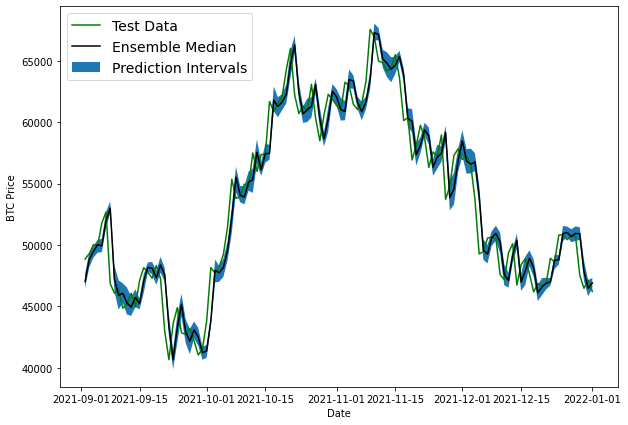

In [66]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=400
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

All our models are lagging, just like the naive model

> NOTE: These predicition intervals are estimates themselves and they've been created with the assumption that our model's data is from a normal distribution.

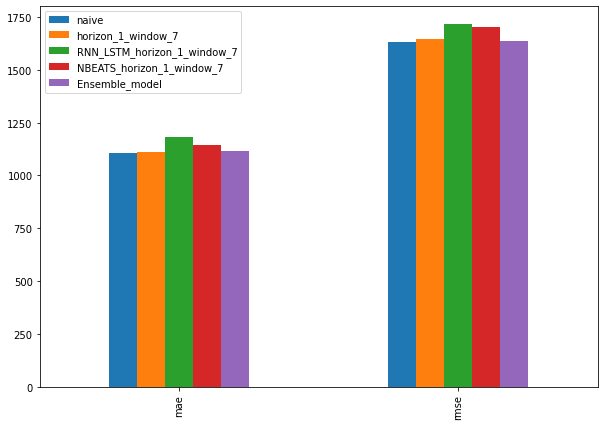

In [68]:
# compare the model results 

pd.DataFrame({"naive": [naive_results["mae"] , naive_results["rmse"]], 
              "horizon_1_window_7": [m1_results["mae"] , m1_results["rmse"]],
              "RNN_LSTM_horizon_1_window_7" : [m2_results["mae"] , m2_results["rmse"]],
              "NBEATS_horizon_1_window_7" : [m3_results["mae"], m3_results["rmse"]],
              "Ensemble_model" : [res["mae"] , res["rmse"]] }, index=["mae" , "rmse"]).plot(figsize=(10, 7), kind="bar");

## Making predictions into the future

Now that we've tested sufficient models, its time to make predictions into the future...

For this purpose we will use a simple Dense model which performs almost as good as the naive baseline model.


In [71]:
# Make a copy
bitcoin_prices_windowed = bitcoin_prices.copy()

# Add windowed columsn
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price + {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)
bitcoin_prices_windowed.head(10)

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [72]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price"], axis = 1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"]
len(X_all) , len(y_all)

(2609, 2609)

In [73]:
# Tun data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [75]:
tf.random.set_seed(42)

from tensorflow.keras import layers

final_model = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
final_model.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
final_model.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions onto the future

* Takes as input:
  1. a list of values
  2. a trained model
  3. a window into the future to predict INTO_FUTURE variable
  4. the window size a model was trained on WINDOW_SIZE as the model can only predict on the kind of data it was trained on.

* Creates an empty list for future forecasts (this will be returned at the end of the end, extract the last window from it)

* Loop INTO_FUTURE times making a predicition on WINDOW_SIZE sequences which update to remove the first value and append the latest prediction

In [76]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # make INTO_FUTURE number of predictions, altering the data whicch gets preedicted on each
  for _ in range(into_future):
    # Predict the last window and append on it 
    future_pred = model.predict(tf.expand_dims(last_window,axis =0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predicitions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get window_size most recent pred
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [84]:
INTO_FUTURE = 14 
future_forecast = make_future_forecast(values=y_all,
                                       model=final_model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 Date
2021-12-26    50430.073507
2021-12-27    50792.036921
2021-12-28    50696.802160
2021-12-29    47535.309698
2021-12-30    46471.230000
2021-12-31    47128.468155
2022-01-01    46208.210437
Name: Price, dtype: float64 -> Prediction: 51091.390625

Predicting on: 
 [50792.036921 50696.80216  47535.309698 46471.23     47128.468155
 46208.210437 51091.390625] -> Prediction: 50201.7578125

Predicting on: 
 [50696.80216   47535.309698  46471.23      47128.468155  46208.210437
 51091.390625  50201.7578125] -> Prediction: 49374.4609375

Predicting on: 
 [47535.309698  46471.23      47128.468155  46208.210437  51091.390625
 50201.7578125 49374.4609375] -> Prediction: 46834.453125

Predicting on: 
 [46471.23      47128.468155  46208.210437  51091.390625  50201.7578125
 49374.4609375 46834.453125 ] -> Prediction: 47620.79296875

Predicting on: 
 [47128.468155   46208.210437   51091.390625   50201.7578125
 49374.4609375  46834.453125   47620.79296875] -> Prediction: 47396.8007

### Plot future forecasts


In [85]:
future_forecast

[51091.39,
 50201.758,
 49374.46,
 46834.453,
 47620.793,
 47396.8,
 49101.742,
 50622.81,
 49750.836,
 48276.55,
 47554.387,
 48249.316,
 48745.598,
 50072.0]

In [86]:
# Returns array of datetime values ranging from start_date till into_future
def get_future_dates(start_date, into_future, offset = 1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype = "datetime64[D]")

In [87]:
last_timestep = bitcoin_prices.index[-1]
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [88]:
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future = INTO_FUTURE)
next_time_steps

array(['2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
       '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09',
       '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
       '2022-01-14', '2022-01-15'], dtype='datetime64[D]')

In [89]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

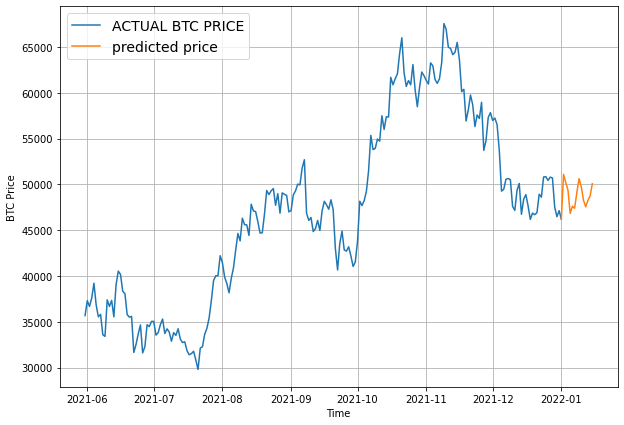

In [90]:
# PLot future prices prediction of bitcoin
plt.figure(figsize = (10,7))
plot_time_series(bitcoin_prices.index, btc_price, start = 2400, format = "-", label= "ACTUAL BTC PRICE")
plot_time_series(next_time_steps, future_forecast, format = "-", label = "predicted price")